# Covid-19 Analysis

## Adrian Tasistro-Hart

This notebook uses data compiled by the New York Times to analyze the development of COVID-19 cases in the US, and compares it with other datasets, including:
- county level race demographics
- county level income demographics

In [1]:
import numpy as np
from scipy.signal import windows, detrend
import scipy.stats as stats
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib import rc
plt.style.use('seaborn-talk')
plt.rc('text.latex', preamble=r'\usepackage{helvet}')

from tqdm import notebook
import ipywidgets as widgets

Note that the FIPS column in the NYTimes data is the same as the GEOID column in the county geometry data.

In [2]:
# NYTimes data
dat = pd.read_csv('us-counties.csv')

# county GIS data
cnt = gpd.read_file('tl_2019_us_county/tl_2019_us_county.shp')
cnt['GEOID'] = cnt['GEOID'].astype(np.int)
cnt.set_index(cnt['GEOID'], inplace=True)

# county level racial demographic data
race = pd.read_csv('ACS_2018_X02_RACE.txt')
# convert to same fips code as in NYTimes data
race.set_index(race['GEOID'].str.split('US', expand=True)[1].astype(np.int), inplace=True)

Now we'll gather other county-level datasets into the county dataframe.

In [3]:
# race
race_cols = ['B02001e1', 'B02001e2', 'B02001e3']
cnt[race_cols] = race[race_cols]

# now get county-scale deaths and cases
cnt_tot_covid = dat.groupby('fips').sum()
# temporary county level dataframe
cnt[list(cnt_tot_covid)] = cnt_tot_covid

## National Cases

In [4]:
tot = dat.groupby('date').sum()[['cases', 'deaths']]
new = tot.diff()

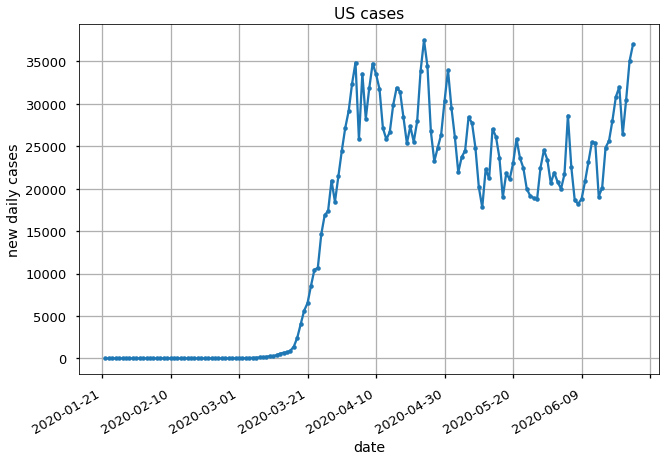

In [5]:
fig = plt.figure()
new['cases'].plot(marker='.')
plt.ylabel('new daily cases')
plt.title('US cases')
plt.grid()
fig.autofmt_xdate()
plt.show()

Right off the bat three clear signals in the time series of new daily cases across the US are:
1. A dramatic increase in late March marking the initial spread of the virus
1. A linear decrease to and stabilization of new daily cases around 22,000 (possibly to increase soon with the arrival of a second wave). 
1. A strong weekly cycle in the new case count, with new cases peaking on Fridays of a given week.

I wanted an excuse to implement multi-taper spectral analysis in python, so the following code blocks show the output of `multitaper()` on the above time series, clearly demonstrating the weekly periodicity.

In [7]:
from scipy.signal import windows

"""
multi-taper spectral density estimation using DPSS sequences as described by Percival and Walden. 

IN:
y: time series of evenly spaced observations in time
dt: sample spacing in sample coordinate
nw: (default 4) time-halfbandwidth product

OUT:
S_est: estimate for the power spectral density estimation
f: frequency axis

TO DO:
- allow user to specify which/how many frequencies to get
"""
def multitaper(y, dt, nw=4):
    N = len(y)
    W = nw/N
    K = int(2*nw-1)
    # frequencies
    f = freq(N, dt)
    Nf = len(f)
    # time indices
    t = np.arange(N)
    # get discrete prolate spheroidal sequence (dpss) windows
    wins = windows.dpss(N, nw, Kmax=K)
    # get tapered spectra
    Sk = np.zeros((Nf, K))
    for ii in range(K):
        # loop over frequencies
        for ff in range(Nf):
            # compute spectral density estimate
            Sk[ff, ii] = dt*np.abs(np.sum(wins[ii,:]*y*np.exp(-1j*2*np.pi*f[ff]*t)))**2
    
    # get eigenvalues for N, W
    evals = dpss_evals(N, W)
    # implement adaptive multitaper spectral estimator (Percival and Walden, pg. 370)
    # start with eqn 369a (i.e. no estimate for weights bk)
    K_cur = 1
    S_est = np.sum(np.tile(evals[0:K_cur], (Nf,1))*Sk[:, 0:K_cur], axis=1)/np.sum(evals[0:K_cur])
    bk = np.zeros((Nf, K))
    # make convenient tiled version of eigenvalues
    evals_tile = np.tile(evals[0:K], (Nf,1))
    # iterate over equations 368a and 370a
    for ii in range(5):
        # get weights
        bk = np.tile(S_est, (K, 1)).T/(evals_tile*np.tile(S_est, (K, 1)).T + (1-evals_tile)*np.var(y))
        # update spectrum
        S_est = np.sum(bk**2*evals_tile*Sk[:, 0:K], axis=1)/np.sum(bk**2*evals_tile, axis=1)

    return S_est, f

# get dpss eigenvalues for given N, W
def dpss_evals(N, W):
    t = np.arange(N)
    t1, t2 = np.meshgrid(t, t)
    dt = t1-t2
    dt[np.diag_indices(N)] = 1
    # construct matrix
    A = np.sin(2*np.pi*W*dt)/(np.pi*dt)
    # set diagonal manually (l'hopital)
    A[np.diag_indices(N)] = 2*W
    # compute eigenvalues (should all be real)
    evals = np.real(np.linalg.eig(A)[0])
    # sort by magnitude 
    evals[::-1].sort()
    return evals

# generate one-sided frequency axis for given N data and dt sample spacing
def freq(N, dt):
    fs = 1/dt
    fi = fs/N
    fx = np.arange(0, fs/2+fi, fi)
    return fx     

In [8]:
S_est, f = multitaper(detrend(new['cases'].values[1:]), 1, 2)

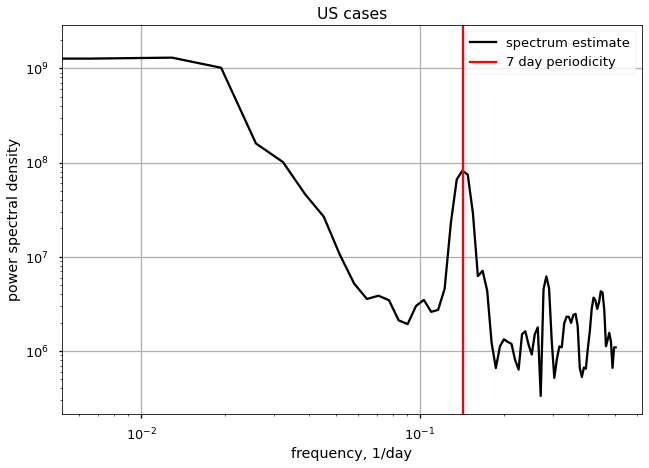

In [9]:
fig = plt.figure()
plt.loglog(f, S_est, 'k')
plt.axvline(1/7, color='r')
plt.xlabel('frequency, 1/day')
plt.ylabel('power spectral density')
plt.title('US cases')
plt.grid()
plt.legend(['spectrum estimate', '7 day periodicity'])
plt.show()

## Specific Counties

Just providing an interface here to quickly plot COVID-19 case and death counts by selected county.

In [26]:
states = np.unique(dat['state'])
counties = np.unique(dat['county'])

state_dropdown = widgets.Dropdown(
    options=states,
    value='Georgia',
    description='State:',
    disabled=False,
)

county_dropdown = widgets.Dropdown(
    options=counties,
    value='Oconee',
    description='County:',
    disabled=False,
)

def update_county_list(*args):
    idx = state_dropdown.value == dat['state']
    county_dropdown.options = np.unique(dat[idx]['county'])
    
state_dropdown.observe(update_county_list, 'value')

col = ['goldenrod', 'firebrick']

def plot_covid_county(state, county):
    idx = np.where((dat['county'] == county) & (dat['state'] == state))
    cur_cnt = dat.iloc[idx]
    cur_cnt.index = pd.DatetimeIndex(cur_cnt['date'])
    fig = plt.figure()
    ax1 = plt.axes()
    ax2 = ax1.twinx()
    ln1 = ax1.plot(cur_cnt['cases'], color=col[0])[0]
    ln2 = ax2.plot(cur_cnt['deaths'], color=col[1])[0]
    ax1.set_ylabel('case count')
    ax2.set_ylabel('death count')
    plt.title('cases in %s County, %s' % (county, state))
    ax1.set_xlim([cur_cnt.index.min(), cur_cnt.index.max()])
    ax2.set_xlim([cur_cnt.index.min(), cur_cnt.index.max()])
    ax1.set_ylim([0, cur_cnt['cases'].max()])
    ax2.set_ylim([0, cur_cnt['deaths'].max()])
    plt.legend([ln1, ln2], ['cases', 'deaths'])
    ax1.grid()
    fig.autofmt_xdate()
    plt.show()
    
w = widgets.interactive(plot_covid_county, {'manual': True}, state=state_dropdown, county=county_dropdown)

display(w)

interactive(children=(Dropdown(description='State:', index=10, options=('Alabama', 'Alaska', 'Arizona', 'Arkan…

## County-scale recent trends

Now I'll determine for each county the population-scaled trends in daily new case occurrences. First, I'll just consider the mean of the daily new-case rate for each county, which is effectively the velocity of the virus spread in each county (as opposed to the trend in the velocity, which the NYTimes plots and serves as a metric of virus spread acceleration). 

In [32]:
win = 14  # window length in number of days for which to compute the trend
trend_col = '%d day trend' % win
fips = cnt['GEOID'].unique()

cnt_trend = pd.DataFrame(index=fips, columns=[trend_col])
for fip in notebook.tqdm(fips):
    tmp_df = dat[dat['fips'] == fip]
    tmp_df.set_index(pd.DatetimeIndex(tmp_df['date']), inplace=True)
    tmp_df = tmp_df['cases'].diff()
    cnt_trend.loc[fip][trend_col] = tmp_df[tmp_df.index > (pd.to_datetime('today')-pd.Timedelta(win, 'd'))].mean()

In [33]:
# add trend data to temporary county dataframe
cnt[trend_col] = cnt_trend[trend_col].astype(np.float)
# normalize
cnt[trend_col] = cnt[trend_col]/cnt['B02001e1']

## Race vs. Covid-19 

Now I want to see how the racial demographics of counties correlates with the spread of the virus.

In [34]:
# compute fractional quantities
cnt['white frac'] = cnt['B02001e2']/cnt['B02001e1']
cnt['black frac'] = cnt['B02001e3']/cnt['B02001e1']
cnt['death frac'] = cnt['deaths']/cnt['cases']

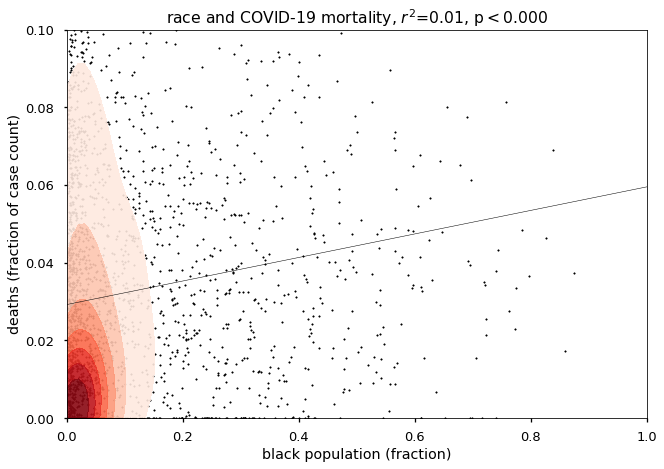

In [35]:
# compute KDE
kde = stats.gaussian_kde(cnt[['black frac', 'death frac']].dropna().values.T, bw_method='scott')

# indices of non nan values
idx = np.logical_not(cnt['black frac'].isna()) & np.logical_not(cnt['death frac'].isna())
# correlation
r, p = stats.pearsonr(cnt[idx]['black frac'], cnt[idx]['death frac'])

# least squares line
pol = np.polyfit(cnt[idx]['black frac'], cnt[idx]['death frac'], 1)

# evaluate on grid
ymax = 0.1
xmax = 1
X, Y = np.meshgrid(np.linspace(0, xmax, 100), np.linspace(0, ymax, 100))
x = X.reshape(-1)
y = Y.reshape(-1)
f = kde(np.row_stack((x,y)))

# plot with contours
plt.figure()
plt.scatter(cnt['black frac'], cnt['death frac'], s=10, marker='.', color='k')
plt.contourf(X, Y, f.reshape(X.shape), cmap='Reds', alpha=0.9, levels=np.linspace(np.max(f)/10, np.max(f), 8))
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100)*pol[0] + pol[1], linewidth=0.5, color='k')
plt.ylim([0, ymax])
plt.xlim([0, xmax])
plt.xlabel('black population (fraction)')
plt.ylabel('deaths (fraction of case count)')
plt.title('race and COVID-19 mortality, $r^2$=%1.2f, p$<$%1.3f' % (r**2, np.round(p, 3)))
plt.show()

This plot demonstrates an extremely weak but significant correlation between the fractional black popoulation in a county and the death rate as a fraction of deaths over reported cases.

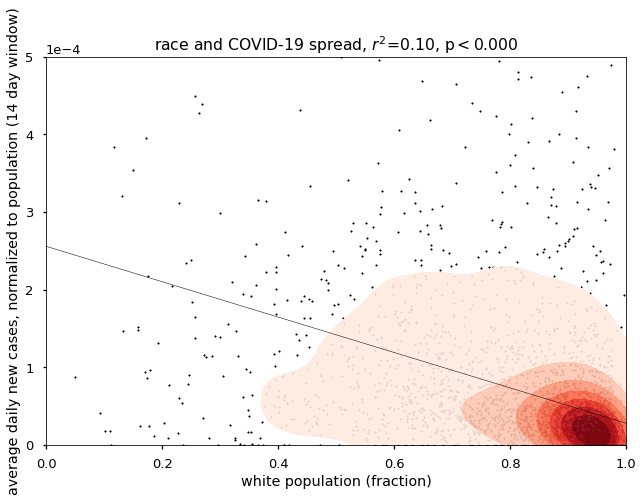

In [36]:
# compute KDE
kde = stats.gaussian_kde(cnt[['white frac', trend_col]].dropna().values.T, bw_method='scott')

# indices of non nan values
idx = np.logical_not(cnt['white frac'].isna()) & np.logical_not(cnt[trend_col].isna())
# correlation
r, p = stats.pearsonr(cnt[idx]['white frac'], cnt[idx][trend_col])

# least squares line
pol = np.polyfit(cnt[idx]['white frac'], cnt[idx][trend_col], 1)

# evaluate on grid
ymax = 5e-4
xmax = 1
X, Y = np.meshgrid(np.linspace(0, xmax, 100), np.linspace(0, ymax, 100))
x = X.reshape(-1)
y = Y.reshape(-1)
f = kde(np.row_stack((x,y)))

# plot with contours
plt.figure()
plt.scatter(cnt['white frac'], cnt[trend_col], s=10, marker='.', color='k')
plt.contourf(X, Y, f.reshape(X.shape), cmap='Reds', alpha=0.9, levels=np.linspace(1000, np.max(f), 8))
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100)*pol[0] + pol[1], linewidth=0.5, color='k')
plt.ylim([0, ymax])
plt.xlim([0, xmax])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel('white population (fraction)')
plt.ylabel('average daily new cases, normalized to population (%d day window)' % win)
plt.title('race and COVID-19 spread, $r^2$=%1.2f, p$<$%1.3f' % (r**2, np.round(p, 3)))
plt.show()

From this plot, we can see that whiteness correlates inversely with the recent daily average new case rates, normalized by total population. The whiter a county, the most slowly COVID-19 spreads there. This correlation is weak but significant, accounting for 10% of the variance in the data.